# 使用谷歌图片搜索做泰迪熊识别

[pyimagesearch](https://link.zhihu.com/?target=https%3A//www.pyimagesearch.com/)网站: 详细的说明[怎样使用谷歌图片搜索创建深度学习数据集](https://link.zhihu.com/?target=https%3A//www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)

### 第一步：收集各类图片的url

到谷歌图片，搜索。在google images，Windows/Linux下点击Ctrl + Shift + J ，在Mac下点击 Cmd + Opt + J ，在显示出的窗口里贴入下面的代码

In [ ]:
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

### 第二步：下载图片

In [4]:
from fastai import *
from fastai.vision import *

使用[Bing-Image-downloader](https://github.com/ostrolucky/Bulk-Bing-Image-downloader)下载图片

Google修改了前端页面，无法直接从单个页面获取全部图片的原始链接，原教材的方法失效

In [5]:
path = Path('data/bears')
classes = ['teddys','grizzly','black']
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

teddys


grizzly


black


In [4]:
help(verify_images)

Help on function verify_images in module fastai.vision.data:

verify_images(path:Union[pathlib.Path, str], delete:bool=True, max_workers:int=4, max_size:int=None, recurse:bool=False, dest:Union[pathlib.Path, str]='.', n_channels:int=3, interp=2, ext:str=None, img_format:str=None, resume:bool=None, **kwargs)
    Check if the images in `path` aren't broken, maybe resize them and copy it in `dest`.



### 第三步：创建ImageDataBunch
当创建data bunch时，如果你没有单独的训练集和验证集，你在参数里可以写训练集是在当前目录（因为默认的，它会去找叫做“train”的目录），我建议把20%的数据作为验证集。这会自动随机使用20%的数据作为验证集。

随机创建验证集时，会在前面把随机种子设为固定值。这样，每次我运行这段代码时，我会得到相同的验证集。

In [7]:
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [8]:
data.classes

['black', 'grizzly', 'teddys']

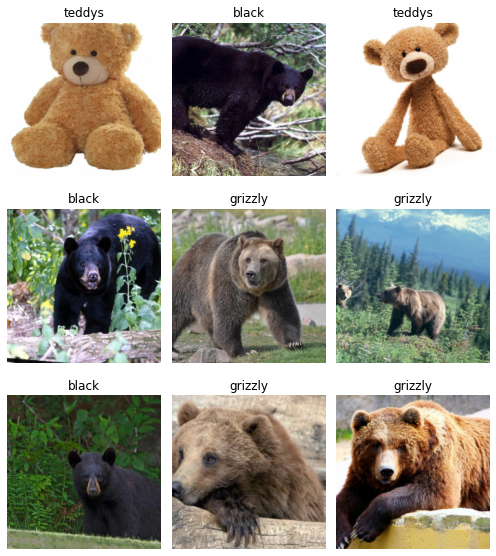

In [9]:
data.show_batch(rows=3, figsize=(7,8))

可以在这里再检查一遍。data.c属性表示数据集里有多少种可能的标签。我们可以看到在训练集里有多少图片，验证集里有多少图片。现在训练集里有456张，验证集里有113张。

In [10]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['black', 'grizzly', 'teddys'], 3, 456, 113)

### 第四步：训练模型
使用resnet34。设置每次迭代打印出错误率。

In [11]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [12]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.243432,0.103422,0.017699,01:39
1,0.618712,0.179194,0.026549,01:37
2,0.403584,0.194049,0.026549,01:37
3,0.290713,0.193745,0.026549,01:38


In [13]:
learn.save('stage-1')

像通常一样，我们解冻模型的其他部分。

In [14]:
learn.unfreeze()

运行学习率查找方法，把它的结果画出来

In [ ]:
learn.lr_find()
learn.recorder.plot()
# 用的cpu，太慢了，就不运行了，直接展示结果

在learning rate finder的图形里，需要找的是这个最长的向下的斜坡。

![结果](https://pic2.zhimg.com/80/v2-5418cc1ce3f3298d4ce23cda64822a01_720w.jpg)

In [15]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.054797,0.485867,0.053097,02:00
1,0.029556,0.377789,0.035398,01:59


In [16]:
learn.save('stage-2')

### 第五步 清洗
使用ClassificationInterpretation类型来看看结果

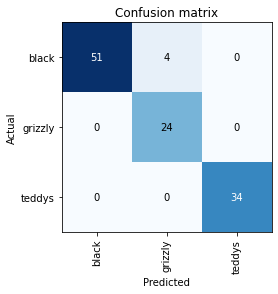

In [17]:
learn.load('stage-2')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

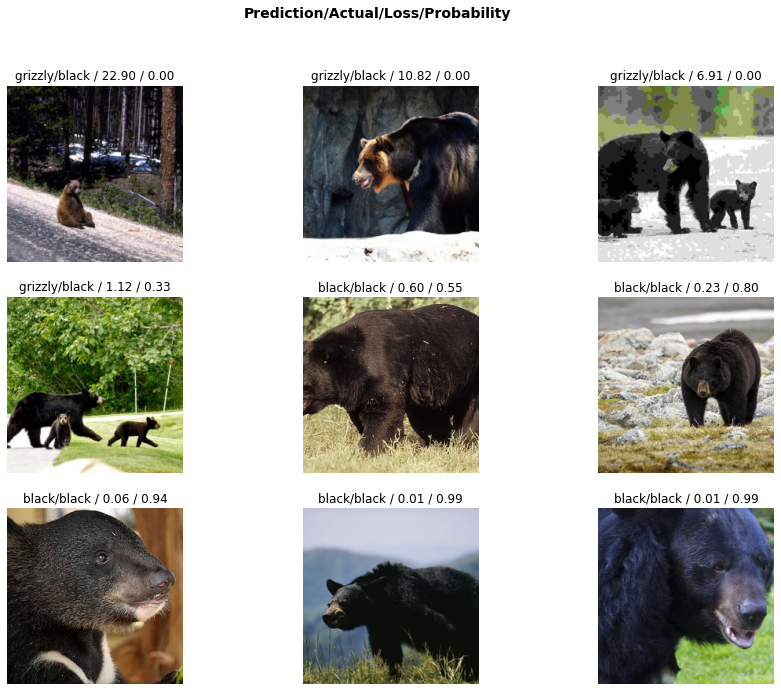

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

#### 5.1 删除一些数据

从混淆矩阵得到有4个黑熊被当成了灰熊。如果我们的数据集更准确的话，我们可能能做得更好。谷歌图片搜索可能不能每次都给出正确的图片。我们怎样解决它呢。我们把它清除掉。

首先，我们需要从`top_loss`中获取文件路径。我们可以使用`.from_toplosses`来实现这一点。然后，我们将最差损失索引和相应的数据集提供给ImageCleaner。

注意，这个小部件不会直接从磁盘中删除图像，但是它会创建一个新的清理过的csv文件，在这个文件中，您可以使用正确的标签创建一个新的ImageDataBunch，以继续训练您的模型。

In [21]:
from fastai.widgets import *

db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [22]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [23]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [24]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

通过点击“Delete”标记要删除的照片。然后点击“Next Batch”删除标记的照片，将其余的保留在那一行。ImageCleaner将显示一列新的图像，直到没有更多的图像可以显示为止。

#### 5.2 删除相同的图片

In [25]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [26]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

使用cleaned.csv重现创建ImageDataBunch

In [7]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

path = Path('data/bears')
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
                               ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [8]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['black', 'grizzly', 'teddys'], 3, 410, 102)

重新训练

In [9]:
learn2 = create_cnn(data, models.resnet34, metrics=error_rate)
learn2.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.180444,0.075183,0.029412,01:32
1,0.585234,0.117364,0.019608,01:31
2,0.386673,0.123763,0.019608,01:31
3,0.278195,0.118468,0.019608,01:31


In [10]:
learn2.save('stage-3');

清洗前：0.026549

清洗后：0.019608

有提升

### 6. 应用训练好的模型

In [11]:
learn2.export()

In [12]:
defaults.device = torch.device('cpu')

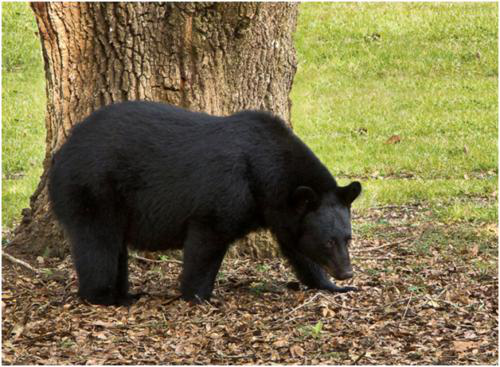

In [13]:
img = open_image(path/'black'/'01.jpg')
img

In [14]:
learn = load_learner(path)
pred_class, pred_idx, outputs = learn.predict(img)
pred_class.obj

'black'

### 7. 一些错误
#### 7.1 学习率太高

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(1, max_lr=0.5) #max_lr默认值是0.003

epoch,train_loss,valid_loss,error_rate,time
0,21.217651,294698976.000000,0.794118,01:34


#### 7.2 学习率太低

In [16]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(5, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,1.883245,1.823414,0.725490,01:32
1,1.955740,1.507304,0.676471,01:31
2,1.921719,1.299292,0.607843,01:32
3,1.839016,1.212059,0.558824,01:31
4,1.846330,1.172346,0.568627,01:32


使用很低的学习率，错误率逐渐改善，但很改善地很慢。

`learn.recorder`是一个保存训练过程日志的对象。你可以调用 `plot_losses` 来画出验证集和训练集的损失度。

你可以看到它们下降的很慢。如果出现了这种情况，就代表你的学习率太低了。把它提高10倍或者100倍，再训练一遍。

如果学习率太低，另一个现象是训练集的损失度比验证集损失度高。这意味着还没有完全拟合，通常是因为学习率太低或者epoch次数太少。所以你的模型出现了这样的情况，要多训练几个epoch或者提高学习率。

#### 7.3 epoch次数太少

如果我们只训练一个epoch会怎样？我们的错误率比随机值要好，只有5%。但是看下这里，看下训练集损失度和验证集损失度的区别——**训练集损失度比验证集高很多**。epoch次数太少和太低的学习率的现象看起来很像。你可以试着多运行几个epoch，如果还是没有效果，就用一个更高的学习率。如果学习率太高，损失度超过了十万，就把学习率调低，少运行几个epoch，找到平衡。

In [17]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, pretrained=False)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.703287,1.238991,0.450980,01:53


#### 7.4 epoch次数太多

epoch次数太多会导致“过拟合”

**识别过拟合的唯一现象是错误率改善了一会后，就变差了**